# Python-Umgebung

In diesem Abschnitt wird die Umgebung für das Arbeiten im Notebook vorbereitet. 

## Import aller verwendeten Bibliotheken

Zunächst werden alle relevanten Pakete für Python importiert:

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## Standard-Look für Plots

Dann werden einige Standard-Einstellungen für das Paket *matplotlib* gesetzt. Diese beeinflussen alle Plots die wir erstellen - so können später mit kleinen Änderungen in diesem Bereich alle Plots gleichzeitig angepasst werden. Typische Beispiele sind Schriftgrößen, Linienstärken etc. Eine Übersicht über die Einstellungsmöglichkeiten findet man z.B. [hier](https://matplotlib.org/stable/tutorials/introductory/customizing.html).

In [24]:
# Dieser Befehl öffnet ein neues Fenster für Plots anstatt sie im Notebook anzuzeigen:
#%matplotlib qt

# Optische Einstellungen
plt.rcParams['figure.figsize'] = [15,6]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14
#plt.rcParams['axes.labelsize'] = 'medium'
#plt.rcParams['legend.fontsize'] = 'large'


# Theorie

## Der lineare Standardkörper

In dieser Übung soll das Verhalten des unten abgebildeten *linearen Standardkörpers* untersucht werden.
<p><img src="standardkoerper.png" width="200" /></p> Dazu schreibt man i.d.R. entweder die Spannung $\sigma$ oder die Dehnung $\varepsilon$ vor, und berechnet die jeweils andere Größe. Im Folgenden werden, wo nicht explizit andere Werte genannt werden, die folgenden <b>Materialparameter</b> verwendet:

| Element               | Parameter  | Wert | Einheit |
|:---------------------:|:----------:|:----:|:-------:|
| Oberes Hooke-Element  | $E_\infty$ | 200  | MPa     |
| Unteres Hooke-Element | $E$        | 200  | MPa     |
| Newton-Element        | $\eta$     | 100  | MPa s   |

### Gleichungen

Zur vollständigen Beschreibung des Systems führen wir für jedes der drei Grundelemente jeweils die zugehörige Dehnung und Spannung ein:

| Element                   | Dehnung               | Spannung            |
|:-------------------------:|:---------------------:|:-------------------:|
| Obere Feder ($E_\infty$)  | $\varepsilon_\infty$  | $\sigma_\infty$     |
| Untere Feder ($E$)        | $\varepsilon_e$       | $\sigma_e$          |
| Dämpfer ($\eta$)          | $\varepsilon_d$       | $\sigma_v$          |

Zunächst gehen wir davon aus dass die Dehnung $\varepsilon$ vorgeschrieben wird. Es verbleiben dann also *sieben Unbekannte*, nämlich $\sigma, \varepsilon_\infty, \varepsilon_e, \varepsilon_v, \sigma_\infty, \sigma_e$ und $\sigma_v$.

Um diese zu bestimmen werden dementsprechen auch *sieben unabhängige Gleichungen* benötigt. Wir erhalten die ersten vier Gleichungen aus den Regeln für Reihen- und Parallelschaltungen:
$$\begin{aligned}
\varepsilon_\infty & = \varepsilon \ ,\\
\varepsilon & = \varepsilon_e + \varepsilon_v \ ,\\
\sigma_v & = \sigma_e \ ,\\
\sigma & = \sigma_\infty + \sigma_e \ .
\end{aligned}$$

Es gelten folgende Gleichungen für die Spannungen der Federn:
$$\begin{aligned}
\sigma_\infty & = E_\infty \, \varepsilon_\infty \ ,\\
\sigma_e & = E \, \varepsilon_e \ .
\end{aligned}$$

Für die Dehnung des Dämpfers gilt die Evolutionsgleichung
$$\dot \varepsilon_v = \frac{1}{\eta}\sigma_v \ .
$$
Anders als bei den anderen Gleichungen handelt es sich hierbei um eine *Differentialgleichung*.

### Lösen des Gleichungssystems

Mittels der ersten sechs Gleichungen können alle bis auf eine Unbekannte aus der Evolutionsgleichung eliminiert werden. Hier wird als verbleibende Unbekannte die *interne Variable* $\varepsilon_v$ gewählt. Es gilt dann
$$\begin{aligned}
\sigma_\infty & = E_\infty \, \varepsilon\ ,\\
\sigma_v & = E \, \left[\varepsilon - \varepsilon_v \right] \ , \\
\sigma & = \sigma_\infty + \sigma_v \ .
\end{aligned}$$

Einsetzen in die Evolutionsgleichung liefert
$$
\dot \varepsilon_v = \frac{E}{\eta}\left[\varepsilon - \varepsilon_v \right] \ .
$$

---
**Aufgabe**

Leite diese Form der Evolutionsgleichung aus den sieben Grundgleichungen her.

---

### Integration der Evolutionsgleichung

Die Evolutionsgleichung wird mittel der *impliziten Euler-Regel* integriert. Ausgehend von bekannten Werten zum Zeitpunkt $n$ gilt dann zum Zeitpunkt $n+1$:
$$\frac{\varepsilon_{v,n+1} - \varepsilon_{v,n}}{\Delta t} = \frac{E}{\eta} \left[\varepsilon_{n+1} - \varepsilon_{v,n+1} \right]$$

Da die Evolutionsgleichung *linear* ist, kann sie nach $\varepsilon_{v}$ umgestellt werden:
$$\varepsilon_{v.n+1} = \frac{\eta \, \varepsilon_{v,n} + \Delta t \, E \, \varepsilon_{n+1}}{\eta + \Delta t \, E}$$

Die Spannung zum Zeitpunkt $n+1$ ergibt sich dann zu
$$
\sigma_{n+1} = E_\infty \varepsilon_{n+1} + E \left[\varepsilon_{n+1} - \varepsilon_{v, n+1}\right] \ .
$$

Im Folgenden wird der Index $(\cdot)_{n+1}$ nicht mehr ausgeschrieben.

---
**Aufgabe**

Zeige, dass die angegebene Lösung für die zeitdiskretisierte Evolutionsgleichung korrekt ist. Wie sieht diese aus, wenn die *explizite Euler-Regel* verwendet wird?

---

# Umsetzung in Python

Um das Verhalten des Standardkörpers zu untersuchen, werden wir die oben hergeleiteten Gleichungen in Python implementieren.


## Bestimmung der Spannungen für gegebene Dehnungen

Es soll zunächst eine Funktion erstellt werden, welche die Spannung $\sigma$ und die interne Variable $\varepsilon_v$ zu einer vorgegebenen Dehnung $\varepsilon$ bestimmt. Dazu werden der Funktion die Materialparameter $E_\infty$, $E$ und $\eta$ sowie die interne Variable aus dem vorherigen Zeitschritt $\varepsilon_{v,n}$ und die Zeitschrittweite $\Delta t$ übergeben.

---
**Aufgabe**

Vervollständige die Funktion `stress` in der nächsten Zelle.

---

In [25]:
# Achtung: Die Benennung der Funktion und die Reihenfolge der Variablen sollte beibehalten werden!
def stress(eps, epsvn, dt, Einf, E, eta):
    # Lösung der Evolutionsgleichung für die viskosen Dehnung
    epsv = (eta*epsvn + dt*E*eps)/(eta+dt*E)
    
    # Resultierende Spannung
    sig = Einf*eps+E*(eps-epsv)
    
    return sig, epsv

Führe die Zelle mit der Funktionsdefinition aus, um diese zu übernehmen. Dann kannst du die folgende Zelle ausführen um deine Lösung zu testen. Wenn deine Lösung noch nicht korrekt sein sollte, kannst du die Funktion anpassen (obere Zelle erneut ausführen um neue Definition zu übernehmen!) und anschließend den Test erneut durchführen.

In [26]:
from musterloesungen import test_stress
test_stress(stress)

Die Funktion ist korrekt.


## Beispiel: Relaxationsversuch

Wir wollen nun die neue Funktion verwenden, um die Spannungsantwort während eines *Relaxationsversuchs* zu bestimmen. Bei diesem Versuch wird eine sprunghaft ansteigende Dehnung aufgeprägt, die anschließend konstant gehalten wird.

---
**Aufgabe**

Vervollständige den Programmcode in der folgenden Zelle, um die gewünschte Dehnung vorzuschreiben.

---

**Hinweis**:
Die numpy-Funktionen [`np.arange`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) und [`np.heaviside`](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html) könnten hilfreich sein...

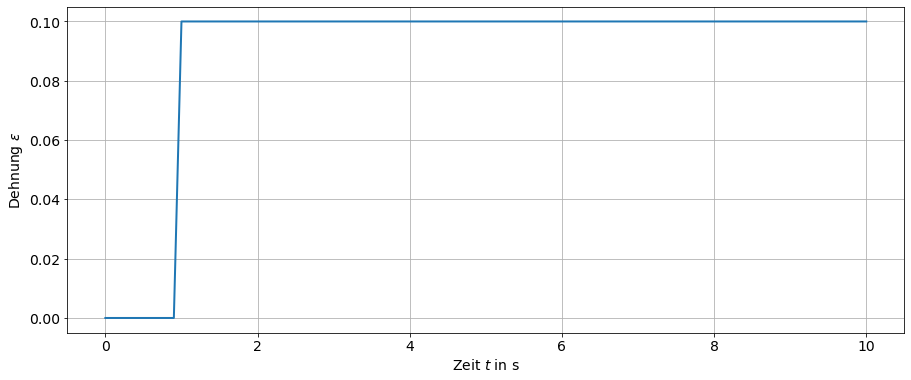

In [27]:
# Start- und Endzeit des Versuchs
tmin, tmax = 0., 10.

# Zeitschrittweite
dt = 0.1

# Zeitpunkt für sprunghaften Anstieg der Dehnung
T1 = 1.0

# Maximalwert der Dehnung
epsmax = 0.1

# Erstellen eines Arrays mit allen diskreten Zeiten
t = np.arange(tmin, tmax+dt, dt)

# Erstellen des Arrays mit den dazugehörigen vorgeschriebenen Dehnungen
eps = np.heaviside(t-T1, 1.)*epsmax

# Plot der Dehnungen - hier musst du nichts ändern
plt.plot(t,eps)
plt.xlabel(r"Zeit $t$ in s")
plt.ylabel(r"Dehnung $\varepsilon$");


---
**Aufgabe**

Vervollständige den Programmcode in der folgenden Zelle, um zu jeder der vorgeschriebenen Dehnungen die zugehörige Spannung $\sigma$ und interne Variable $\varepsilon_v$ zu bestimmen.

---

**Hinweise**:
- Du solltest die folgende Zelle erst dann bearbeiten, wenn die Dehnungen in der vorherigen Zelle korrekt sind.
- Für den ersten Zeitpunkt $t=0$ gehen wir davon aus, dass die interne Variable den Wert 0 hat.

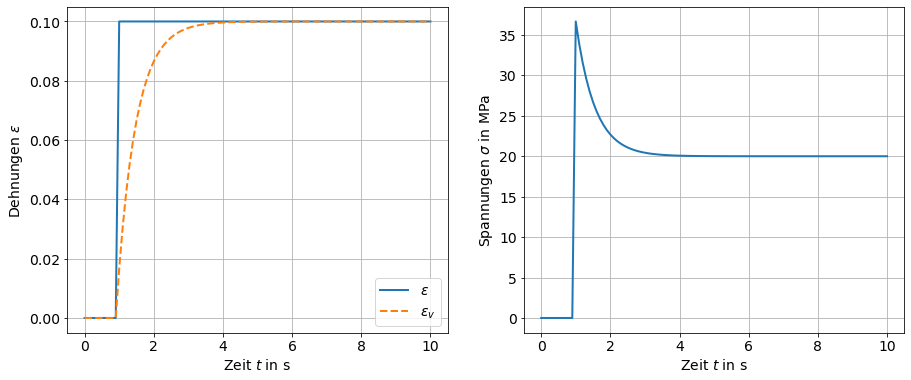

In [28]:
# Materialparameter
E = 200.
eta = 100.
Einf = 200.

# Leere Arrays für Spannung und interne Variable
sig = np.zeros_like(eps)
epsv = np.zeros_like(eps) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

# Schleife über Zeitschritte
for i in range(1,len(eps)):
    sig[i], epsv[i] = stress(eps[i], epsv[i-1], dt, Einf, E, eta)

# Plots - hier musst du wieder nichts ändern...
plt.subplot(121)
plt.plot(t, eps, label=r'$\varepsilon$')
plt.plot(t, epsv, '--', label=r'$\varepsilon_v$')
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$')

plt.subplot(122)
plt.plot(t, sig, label=r'$\sigma$')
plt.xlabel('t');
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$');



---
**Aufgabe**

Interpretiere die Ergebnisse. Entsprechen diese deinen Erwartungen? Was passiert, wenn du einzelne Materialparameter änderst?

---

# Numerische Lösung des Gleichungssystems

## Residuales Format

Anstatt die zeitdiskretisierte Evolutionsgleichung "von Hand" umzuformen und zu lösen, können wir die Evolutionsgleichung und die konstitutive Gleichung numerisch lösen. Dazu werden die Gleichungen im residualen Format aufgestellt. Natürlich können trotzdem bereits vorher einzelne Variablen eliminiert werden. Hier betrachten wir die Spannung $\sigma$ und die interne Variable $\varepsilon_v$ als Unbekannte. Dementsprechend lautet das Residuum

$$
\mathbf{r} = \begin{bmatrix}
\sigma_{n+1} - \sigma_{\infty,n+1} - \sigma_{v,n+1} \\
\dfrac{\varepsilon_{v,n+1} - \varepsilon_{v,n}}{\Delta t} - \dfrac{1}{\eta}\sigma_{v,n+1}
\end{bmatrix} = \mathbf 0
\ ,$$
wobei gilt
$$\begin{aligned}
\sigma_{\infty,n+1} & = E_\infty \varepsilon_{n+1} \ , \\
\sigma_{v,n+1} & = E \left[\varepsilon_{n+1} - \varepsilon_{v,n+1}\right] \ .
\end{aligned}$$

Das residuale Format ist insbesondere dann hilfreich, wenn für kompliziertere Modelle nichtlineare Gleichungen entstehen, die nicht mehr direkt gelöst werden können.

---
**Aufgabe**

Vervollständige die Funktion `res` zur Bestimmung des Residuums.

---


In [29]:
def res(eps, sig, epsv, epsvn, dt, Einf, E, eta):
    """Residuum für gegebene Verzerrung, Spannung, interne Variable."""
    
    # Hilfswerte
    siginf = Einf*eps
    sigv = E*(eps-epsv)
    
    # Residuum
    r1 = sig - siginf - sigv
    r2 = (epsv - epsvn)/dt - sigv/eta
    
    return np.array([r1, r2])

So wie bereits oben kannst du deine Lösung überprüfen indem die die nächste Zelle ausführst. Denke daran, bei Änderungen jeweils beide Zellen neu auszuführen.

In [30]:
from musterloesungen import test_residuum
test_residuum(res)

Die Funktion ist korrekt.


## Gleichungslöser

Es gilt nun, die Gleichung $\boldsymbol r = \boldsymbol 0$ nach den Variablen $\sigma$ und $\varepsilon_v$ zu lösen. Für diese "Standard-Aufgabe" verwenden wir hier die Funktion [`fsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) aus dem Paket `scipy`.

`fsolve` benötigt (mindestens) die folgenden Argumente:
- Eine Funktion `f`, welche als einziges Argument ein Array `x` mit den Werten der Unbekannten (hier $\sigma$ und $\varepsilon_v$) erhält. Alle weiteren Größen werden konstant gehalten, da sie bekannt sind bzw. vorgeschrieben werden.
- Ein Array `x0` mit Startwerten für die Unbekannten. Hier wird zunächst immer $\boldsymbol x_0 = \boldsymbol 0$ verwendet.

---
**Aufgabe**

Vervollständige die Funktion `stress_res` zur Bestimmung der Spannungen und internen Variablen basierend auf der Residuumsfunktion.

---


In [31]:
def stress_res(eps, epsvn, dt, Einf, E, eta, x0=np.array([0.,0.])):
    """Lösung der Residuumsgleichung nach Spannung und interner Variable"""
    
    # f ist die Funktion, die das Residuum für verschiedene Werte von
    # sigma und epsv auswertet.
    f = lambda x: res(eps, x[0], x[1], epsvn, dt, Einf, E, eta)
    
    # Mit der Funktion fsolve wird eine Lösung des Gleichungssystems
    # gesucht.
    x = fsolve(f, x0)
    
    # Wir überprüfen noch einmal, dass die gefundene Lösung x die
    # Residuumsgleichung tatsächlich löst
    assert np.allclose(f(x), np.zeros_like(x))
    
    # Wie zuvor geben wir hier Spannung und interne Variable einzeln zurück
    return x[0], x[1]

Wie du deine Lösung überprüfen kannst weißt du jetzt ja bereits... :-)

In [32]:
from musterloesungen import test_stress_res
test_stress_res(stress_res)

Die Funktion ist korrekt.


## Vergleich: Umformen vs. residuales Format

Im Folgenden werden die beiden Lösungmethoden für den Relaxationsversuch verwendet und die Ergebnisse verglichen. Wenn beide Varianten korrekt implementiert wurden, sollte hier kein Unterschied sichtbar sein.

---
**Aufgabe**

Kopiere den Code für den Relaxationsversuch und erweitere ihn, sodass beide Lösungen verglichen werden.

---

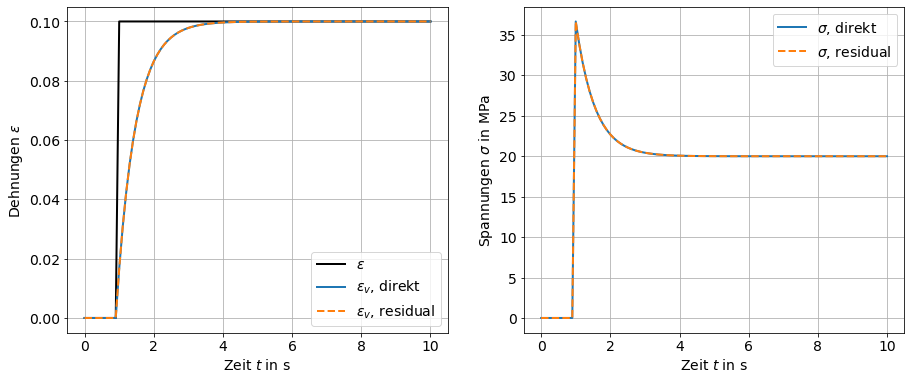

In [33]:
# Materialparameter
E = 200.
eta = 100.
Einf = 200.

# Leere Arrays für Spannung und interne Variable
sig = np.zeros_like(eps)
epsv = np.zeros_like(eps) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

sig_res = np.zeros_like(eps)
epsv_res = np.zeros_like(eps)

# Schleife über Zeitschritte
for i in range(1,len(eps)):
    sig[i], epsv[i] = stress(eps[i], epsv[i-1], dt, Einf, E, eta)
    sig_res[i], epsv_res[i] = stress_res(eps[i], epsv_res[i-1], dt, Einf, E, eta)
    
# Plots - hier musst du wieder nichts ändern...
plt.subplot(121)
plt.plot(t, eps, 'k', label=r'$\varepsilon$')
plt.plot(t, epsv, '-', label=r'$\varepsilon_v$, direkt')
plt.plot(t, epsv_res, '--', label=r'$\varepsilon_v$, residual')
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$')

plt.subplot(122)
plt.plot(t, sig, label=r'$\sigma$, direkt')
plt.plot(t, sig_res, '--', label=r'$\sigma$, residual')
plt.xlabel('t');
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$')
plt.legend();


# Inverses Problem

Bisher haben wir die Dehnung vorgeschrieben und die Spannung ausgewertet. Oft ist aber auch das inverse Problem interessant: Die Spannung wird aufgeprägt und die Dehnung gesucht.

Da alle verwendeten Gleichungen linear sind, kann die Evolutionsgleichung anstatt in den Dehnungen auch in den Spannungen formuliert werden. Allerdings zeigt sich hier der Vorteil des residualen Formats: Mit kleinen Anpassungen kann das gleiche System von Gleichungen für andere Unbekannte gelöst werden.

---
**Aufgabe**

Vervollständige die Funktion `strain_res` zur Bestimmung der Dehnung und internen Variablen basierend auf der Residuumsfunktion.

---


In [34]:
def strain_res(sig, epsvn, dt, Einf, E, eta, x0=np.array([0.,0.])):
    """Lösung der Residuumsgleichung nach Dehnung und interner Variable"""
    
    # f ist die Funktion, die das Residuum für verschiedene Werte von
    # eps und epsv auswertet.
    f = lambda x: res(x[0], sig, x[1], epsvn, dt, Einf, E, eta)
    
    # Mit der Funktion fsolve wird eine Lösung des Gleichungssystems
    # gesucht.
    x = fsolve(f, x0)
    
    # Wir überprüfen noch einmal, dass die gefundene Lösung x die
    # Residuumsgleichung tatsächlich löst
    assert np.allclose(f(x), np.zeros_like(x))
    
    # Wie zuvor geben wir hier Dehnung und interne Variable einzeln zurück
    return x[0], x[1]

Prüfung der Funktion:

In [35]:
from musterloesungen import test_strain_res
test_strain_res(strain_res)

Die Funktion ist korrekt.


## Beispiel: Kriechversuch

Beim *Kriechversuch* wird eine Spannung vorgeschrieben, die sprunghaft ansteigt und dann gehalten wird.

---
**Aufgabe**

Vervollständige den Programmcode in der folgenden Zelle um die Dehnung während des Kriechversuchs zu bestimmen.

---

**Hinweis**:
Orientiere dich bei der Implementierung am Relaxationsversuch.

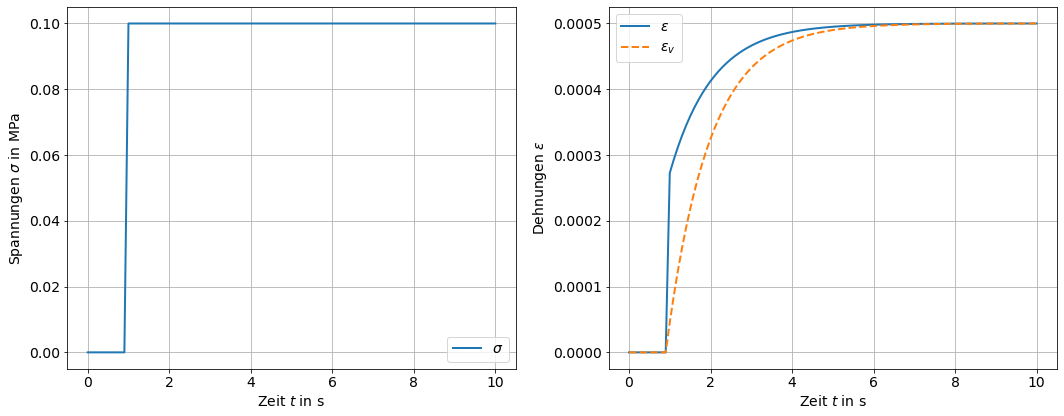

In [37]:
# Start- und Endzeit des Versuchs
tmin, tmax = 0., 10.

# Zeitschrittweite
dt = 0.1

# Zeitpunkt für sprunghaften Anstieg der Spannung
T1 = 1.0

# Maximalwert der Spannung
sigmax = 0.1

# Erstellen eines Arrays mit allen diskreten Zeiten
t = np.arange(tmin, tmax+dt, dt)

# Erstellen des Arrays mit den dazugehörigen vorgeschriebenen Spannungen
sig = np.heaviside(t-T1, 1.)*sigmax


# Materialparameter
E = 200.
eta = 100.
Einf = 200.


# Leere Arrays für Dehnung und interne Variable
eps = np.zeros_like(sig)
epsv = np.zeros_like(sig) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

# Schleife über Zeitschritte
for i in range(1,len(sig)):
    eps[i], epsv[i] = strain_res(sig[i], epsv[i-1], dt, Einf, E, eta)


# Plots
plt.subplot(121)
plt.plot(t, sig, label=r'$\sigma$')
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$')

plt.subplot(122)
plt.plot(t, eps, label=r'$\varepsilon$')
plt.plot(t, epsv, '--', label=r'$\varepsilon_v$')
plt.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$');

plt.tight_layout()


# Anwendung des Modells

Nachdem wir das Verhalten des Standardkörpers mit unserem Programm nun beschreiben können, können wir z.B. Parameterstudien durchführen um den Einfluss der einzelnen Modellparameter zu untersuchen. Eine andere Möglichkeit ist die Anwendung des Modells auf komplexere Lastpfade.

## Parameterstudie: Relaxationsversuch mit wechselnden Materialparametern

Wir wiederholen die Berechnung des Relaxationsversuchs nun in einer Schleife. In jedem Durchlauf soll ein anderer Satz von Materialparametern ($E_\infty$, $E$, $\eta$) vorgeschrieben werden.

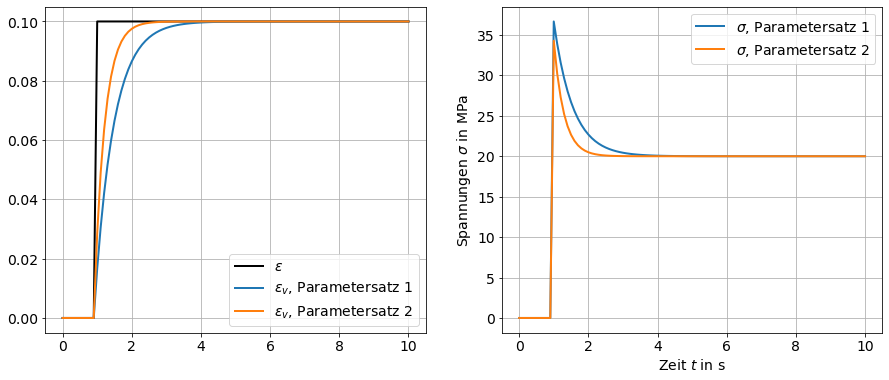

In [50]:
# Start- und Endzeit des Versuchs
tmin, tmax = 0., 10.

# Zeitschrittweite
dt = 0.1

# Zeitpunkt für sprunghaften Anstieg der Dehnung
T1 = 1.0

# Maximalwert der Dehnung
epsmax = 0.1

# Erstellen eines Arrays mit allen diskreten Zeiten
t = np.arange(tmin, tmax+dt, dt)

# Erstellen des Arrays mit den dazugehörigen vorgeschriebenen Dehnungen
eps = np.heaviside(t-T1, 1.)*epsmax

p1 = plt.subplot(121)
plt.plot(t, eps, 'k', label=r'$\varepsilon$')

p2 = plt.subplot(122)

# Materialparameter
#             Einf   eta     E
matParams = [(200,   100,   200),  # Parametersatz 1
             (200,    50,   200),  # Parametersatz 2
            ]

for iParam in range(len(matParams)):
    Einf, eta, E = matParams[iParam]

    # Leere Arrays für Spannung und interne Variable
    sig = np.zeros_like(eps)
    epsv = np.zeros_like(eps) # enthält für t=0 bereits die Anfangsbedingung für die interne Variable

    # Schleife über Zeitschritte
    for iTime in range(1,len(eps)):
        sig[iTime], epsv[iTime] = stress(eps[iTime], epsv[iTime-1], dt, Einf, E, eta)

    # Plots - hier musst du wieder nichts ändern...
    p1.plot(t, epsv, label=r'$\varepsilon_v$, Parametersatz %d' % (iParam+1))

    p2.plot(t, sig, label=r'$\sigma$, Parametersatz %d' % (iParam+1))

    

p1.legend()
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Dehnungen $\varepsilon$')
   
p2.legend()
plt.xlabel('t')
plt.xlabel(r'Zeit $t$ in $\mathrm{s}$ ')
plt.ylabel(r'Spannungen $\sigma$ in $\mathrm{MPa}$');



# Weiterführende Aufgaben

Die folgenden Aufgaben können selbstständig bearbeitet werden, um das eigene Verständnis zu verbessern und sich intensiver mit dem Programm auseinander zu setzen

- Erweitere deinen Code, sodass die einzelnen Komponenten der Spannungen geplottet werden. Überlege zunächst, wie dies mit möglichst geringen Änderungen erreicht werden kann.
- Erweitere die Parameterstudie um weitere Kombinationen von Parametern.
- Implementiere einen komplizierteren Lastfall, z.B. eine zyklisch wechselnde Last. Dabei kann z.B. die Funktion [`scipy.signal.sawtooth`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html) hilfreich sein. Überprüfe die vorgeschriebene Dehnung/Spannung mit einem Plot bevor du das Modell benutzt um die Antwort des Standardkörpers zu untersuchen.